<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter07/Training_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Two-stage Detector - R-CNN
**Ross Girshich, Jeff Donahue, Trevor Darrell, Jitendra Malik et al, "Rich feature hierarchies for accurate onject detection and semantic segmentation", R-CNN**
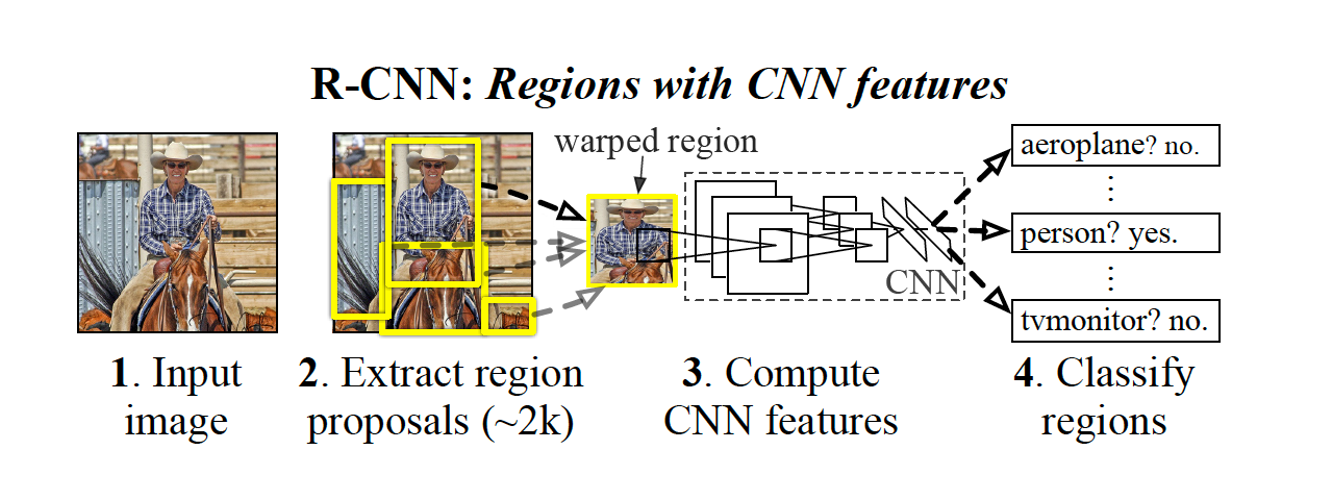
<br>
<center>R-CNN 논문 일부</center>

***R-CNN (Region-based Convolution Neural Network)***

이름에서도 나오듯 지역 기반의 CNN이다. 정확히는 Region Proposal(지역 제안)을 말한다. 위 그림은 R-CNN의 process를 의미한다.

① **모형에 image를 넣는다.** <br>
② **2000장의 bottom-up region proposal을 얻은 후, warped(resize) 해준다.**<br> 
    - region proposal을 하는 이유는 이미지 내의 잠재적인 개체를 놓치지 않게 하기 위해서이다.<br>
③ **각각의 region proposal을 CNN을 이용하여 feature를 계산한다.** <br>
    - 일반적으로 ResNet50이나 VGG16 등의 pretrained model을 통해 전달하고 FC Layer를 이용하여 feature를 추출한다. <br>
④ **SVMs를 이용하여 각 region의 Class를 예측한다.**<br>
    - ③을 통해 추출된 feature를 input으로 하고 output은 각각의 region의 class corresponding과 ground truth로부터 region proposal의 offset(regressor)이다.
    

마지막 말을 예시로 다시 알아보자.
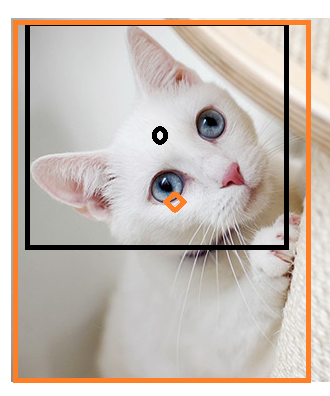
출처 : https://www.mk.co.kr/news/culture/view/2021/06/535745/

- 검정 동그라미 = region proposal의 중심()
- 주황 다이아몬드 = ground truth의 중심
- offset 계산 = 두 Bounding box의 center 좌표(dx,dy)와 weight, height 좌표(dw,dh)

### 진행 방법(목차)

1) 데이터 준비 및 확인<br>
2) Region proposal 표현 함수, IoU 계산 함수 정의<br>
3) Training data 생성<br>
input, 
- Resize Region Proposal(input 데이터 크기 맞춰주기)<br>
- pretrained된 VGG16을 이용하여 feature 추출<br>

output,
- 각각의 Region마다 Object or Background인지 여부가 나옴
- 

4) Training model 정의<br>
5) Training data 학습<br>
6) test(새로운 데이터)<br>

### 패키지 업로드

In [1]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch as ss

from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 1) 데이터 준비 및 확인
https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks 

kaggle에 있는 데이터를 이용하여 실습을 진행한다. 위 데이터 안에는 images 폴더와 df.csv 파일이 들어있다. 
- **images**
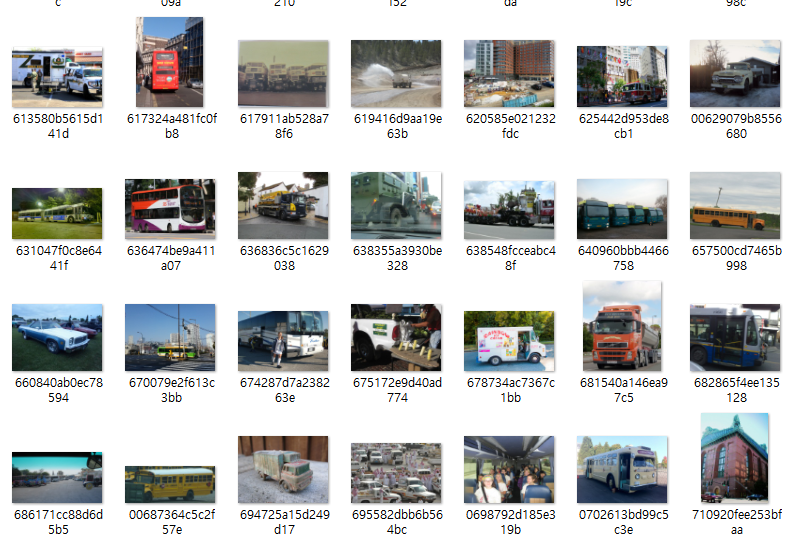    
    images/imgaes 폴더 안에는 다음과 같이 이미지가 있다.
- **df.csv**<br> 
이미지들에 대한 설명과 bounding box ground truth 값이 적혀있다. 밑을 살펴보자.

In [2]:
image_root = './data/images/images'
data = pd.read_csv('./data/df.csv')
print(data.head(3))
print(data.columns)
print(data.shape)

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  

[3 rows x 21 columns]
Index(['ImageI

df.csv 파일이 가지고 있는 columns(열)은 21개이다.
- ImageID : 이미지 파일 이름
- Source : xclick or activemil
- LabelName : Truck or Bus
- XMin : X 최소(Ground Truth의 Bounding Box 좌표 값)
- XMax : X 최대(Ground Truth의 Bounding Box 좌표 값)
- YMin : Y 최소(Ground Truth의 Bounding Box 좌표 값)
- YMax : Y 최대(Ground Truth의 Bounding Box 좌표 값)
- Confidence ,IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside, XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y 열이 존재


데이터 확인

./data/images/images/00072b81abc72d21.jpg


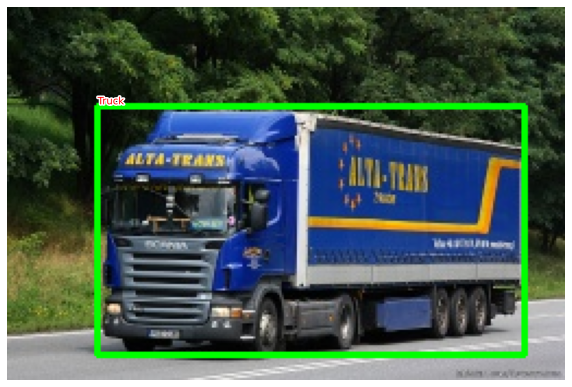

In [3]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=image_root):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): 
        return len(self.unique_images)
    
    # ix는 image_id의 index
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        # Image : BGR -> RGB로 변경 
        image = cv2.imread(image_path, 1)[...,::-1] 
        h, w, _ = image.shape
        # 원본 훼손 방지를 위해 copy
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        # (24062,4) * (4,) 를 list로 변환
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=data)
im, bbs, clss, _ = ds[9]
print(_)
show(im, bbs=bbs, texts=clss, sz=10)

#### [Summary]
- 위 단계에서는 먼저, 실습할 데이터를 다운로드하고, csv 파일에서 필요한 부분만 가져오는 Class를 정의하였다.
- ds = OpenImages(df=data) 를 이용하여 ds 안에 image, boxes 좌표, classes, image_path를 저장하였다.

### 2) Region Proposal, IoU

#### 2-1) Region Proposal

Selective Search는 pixel intensities를 기반으로 함께 그룹화될 가능성이 있는 region의 proposal을 생성하는 object localization에 사용되는 region proposal algorithm이다.

**region proposals을 생성하기 위한 Selective Search 함수**

- **img_lbl, regions = ss.selective_search(img, scale, min_size)**
    - img : input image
    - scale : object의 size
    - min_size : region proposal 할 때 최소의 bounding box
- 반환된 값에서 regions는 dictionary 형태의 값을 가진다.
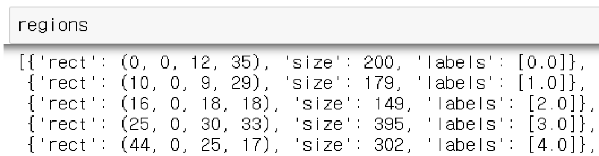

In [5]:
def extract_candidates(img):
    # object size가 200, 최소 bounding box size 100
    img_lbl, regions = ss.selective_search(img, scale=200, min_size=100)
    # np.prod : 배열 요소의 곱
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: 
            continue
        if r['size'] < (0.05*img_area): 
            continue
        if r['size'] > (1*img_area): 
            continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

extract_candidates : selective search 알고리즘을 이용하여 나온 region proposal의 boxes 좌표 값 저장하는 함수 

✔ 0.05*img_area > r[size] , r[size] > 1*img_area 이유는?

#### 2-2) IoU 계산 함수

In [6]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) # boxA의 넓이
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]) # boxB의 넓이
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

**전체 데이터(ds)에 대하여 Region Propoal 구하기**
- FPATHS : 저장된 파일의 path
- GTBBS : Ground Truth의 Bounding Box
- CLSS : Object의 class
- DELTAS : Ground Truth, Region Proposal의 offset(계산 값)
- ROIS : Region Proposal Locations
- IOUS : Ground Truth, Region Proposal의 IoU

In [7]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    # region proposal의 x,y,w,h
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates]) # (x1,y1,x2,y2)
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] 
                     for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        # 최대값 위치 반환
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: 
            clss.append(labels[best_iou_at]) # Object 종류
        else : 
            clss.append('background') # Background
        # 현재 proposal의 margins를 조정해서 best_bb와 일치하도록 함
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{image_root}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

1) bbs(ground truth bounding box)와 candidates(region proposal box)의 iou<br>
2) 각 이미지 별 최대의 iou를 가지는 값을 추출 -> iou가 0.3이 넘으면 class를 반환, 아니면 background라고 라벨링<br>

✔ delta가 의미하는 바가 정확하게 뭔지 모르겠다. 가장 좋은 proposal과 best_bb의 값이 다를 수 있으니 조정해준다?!

In [8]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [9]:
targets

,label
0,Bus
1,Bus
2,background
3,Bus
4,background
...,...
20158,Truck
20159,Truck
20160,Truck
20161,Truck


In [10]:
label2target

{'Bus': 0, 'background': 1, 'Truck': 2}

#### [Summary]

- 이 단계에서는 필요한 함수를 정의하는 단계이다.
- Region Proposal을 구하기 위한 extra_candidates 함수, iou 값을 계산하기 위한 extra_iou 함수를 정의하였다.
- 이를 ds에 적용하여 전체 데이터에 대하여 targets 값을 얻었다.

### 3) Training data 생성

**이미지 프로세싱 함수**

In [11]:
# RGB 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1) # W,H,C -> C,W,H
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds


✔ decode가 무슨 의미일까?!

#### custom dataset

class를 정의할 때 image를 전부 resize하여 같은 크기(224,224)로 만든다.

In [26]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1] 
        print(image.shape)
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

**Data Loader**

In [32]:
n_train = 9*len(FPATHS)//10 # 450
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2,shuffle=True, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2,shuffle=False, collate_fn=test_ds.collate_fn, drop_last=True)

In [33]:
for x,y,z in train_loader:
    print(x.shape)
    print(y.shape)
    print(z)
    break

(192, 256, 3)
(140, 256, 3)
torch.Size([92, 3, 224, 224])
torch.Size([92])
tensor([[-0.2461,  0.0729,  0.0000,  0.7552],
        [ 0.0312, -0.5833,  0.5039, -0.0885],
        [-0.5352, -0.0625,  0.0508,  0.1979],
        [ 0.0312, -0.5833,  0.5039, -0.0885],
        [ 0.0312, -0.4688,  0.5039, -0.0885],
        [-0.5352, -0.0625,  0.0000,  0.1979],
        [ 0.0312, -0.4688,  0.5039, -0.0885],
        [-0.0039, -0.1198,  0.6914,  0.1615],
        [-0.3242, -0.4740,  0.0000,  0.1250],
        [-0.2461,  0.0729,  0.0000,  0.7552],
        [ 0.0195, -0.1198,  0.6914,  0.1042],
        [-0.5352, -0.0260,  0.0000,  0.1979],
        [-0.3242, -0.4740,  0.0000,  0.0781],
        [ 0.0195, -0.1198,  0.6914,  0.1042],
        [ 0.0312, -0.1198,  0.5039, -0.0885],
        [-0.1680, -0.0104,  0.0039,  0.4740],
        [-0.1602, -0.3073,  0.4336,  0.1250],
        [-0.1602, -0.0104,  0.0039,  0.1250],
        [-0.5352, -0.0260,  0.0000,  0.1979],
        [-0.2617, -0.4740,  0.0000, -0.0625],
     

#### [Summary]

- 전 단계에서 만들어준 data를 이용하여 Training dataset을 생성하였다.
- 그 후, Data Loader를 이용하여 batch size만큼 묶어서 데이터를 묶어주었다.

### 4) Training Model 정의

#### 4-1) Backbone - VGG16

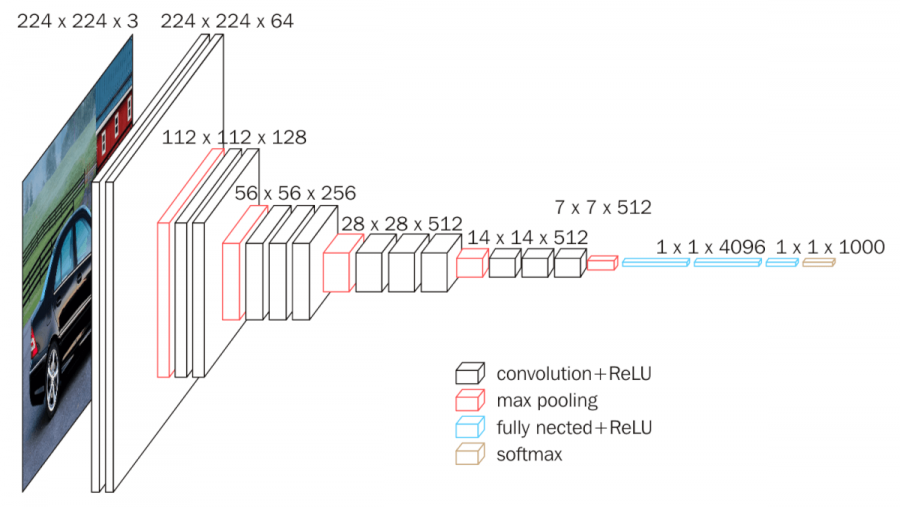
출처 : https://bskyvision.com/504

In [34]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()

# pretrained에서 썼던 weighrs를 그대로 가져오겠다.
for param in vgg_backbone.parameters():
    param.requires_grad = False
    
vgg_backbone.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### 4-2) R-CNN

In [35]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088 # 7*7*512
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss() # Classification
        self.sl1 = nn.L1Loss() # Regression
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

#### [Summary]

- 모형을 정의하였다!

### 5) Training


- detach() : gradient 계산 x

In [36]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [37]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [38]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

(171, 256, 3)
(192, 256, 3)


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 0.004	trn_loss: 4.671	trn_loc_loss: 1.314	trn_regr_loss: 0.336	trn_acc: 0.165	(0.46s - 515.40s remaining)(165, 256, 3)
(256, 256, 3)
EPOCH: 0.009	trn_loss: 4.179	trn_loc_loss: 1.195	trn_regr_loss: 0.298	trn_acc: 0.547	(0.64s - 359.60s remaining)(106, 256, 3)
(162, 256, 3)
EPOCH: 0.013	trn_loss: 4.872	trn_loc_loss: 1.956	trn_regr_loss: 0.292	trn_acc: 0.296	(0.82s - 305.53s remaining)(192, 256, 3)
(170, 256, 3)
EPOCH: 0.018	trn_loss: 5.146	trn_loc_loss: 1.816	trn_regr_loss: 0.333	trn_acc: 0.115	(1.03s - 289.79s remaining)(171, 256, 3)
(180, 256, 3)
EPOCH: 0.022	trn_loss: 3.920	trn_loc_loss: 1.042	trn_regr_loss: 0.288	trn_acc: 0.667	(1.22s - 272.97s remaining)(192, 256, 3)
(256, 192, 3)
EPOCH: 0.027	trn_loss: 3.250	trn_loc_loss: 1.213	trn_regr_loss: 0.204	trn_acc: 0.451	(1.38s - 257.81s remaining)(206, 256, 3)
(171, 256, 3)
EPOCH: 0.031	trn_loss: 4.262	trn_loc_loss: 0.678	trn_regr_loss: 0.358	trn_acc: 0.697	(1.57s - 250.77s remaining)(171, 256, 3)
(256, 192, 3)
EPOCH: 0.036	trn_los

100%|██████████| 106/106 [00:00<00:00, 6373.41it/s]


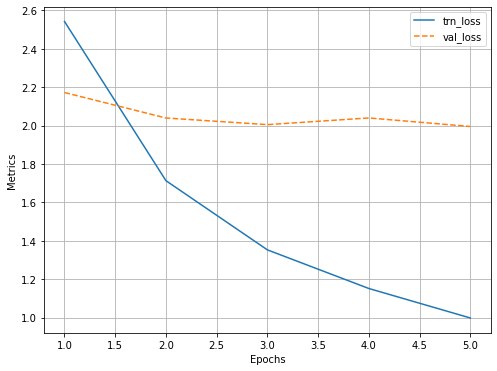

In [39]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

### 6) Test

In [40]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

(176, 256, 3)


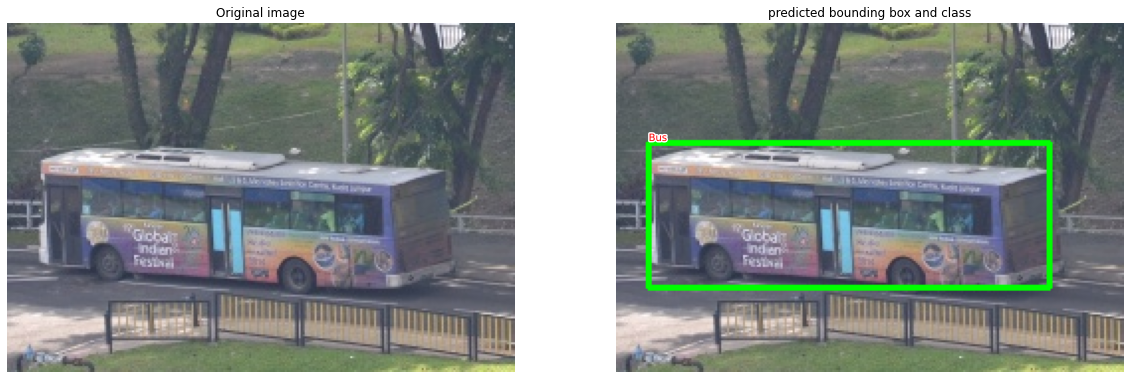

((16, 60, 218, 133), 'Bus', 0.9818872)

In [41]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)